In [28]:
!pip install yfinance

In [29]:
import numpy as np 
import pandas as pd
import os
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import random
import yfinance as yf
from scipy.optimize import LinearConstraint, Bounds, NonlinearConstraint
from scipy.stats import norm, t
import scipy.stats as st

**DEFINE FUNCTIONS TO DOWNLOAD AND ANALYZE DATA**


In [30]:
def Returns(stocks,end,start):
    s = [stock for stock in stocks]
    data = yf.download(s, start=start, end=end)
    pct_change = data['Close'].pct_change()
    mean_returns = pct_change.mean()
    cov_matrix = pct_change.cov()
    
    return pct_change, data, mean_returns, cov_matrix

def Portofolio_Returns(weights, mean_returns, cov_matrix, trading_days):
    portofolio_returns = np.sum(mean_returns*weights)*trading_days
    portofolio_std = np.sqrt(np.dot(weights.T,np.dot(cov_matrix,weights)))*np.sqrt(trading_days)
    
    return round(portofolio_returns,4), round(portofolio_std,4)

def Sharpe_Ratio(weights, mean_returns, cov_matrix, trading_days,risk_free_rate=0):
    portofolio_returns, portofolio_std = Portofolio_Returns(weights, mean_returns, cov_matrix, trading_days)
    return (portofolio_returns-risk_free_rate)/portofolio_std

def Negative_Sharpe_Ratio(weights, mean_returns, cov_matrix, trading_days,risk_free_rate=0):
    return -Sharpe_Ratio(weights, mean_returns, cov_matrix, trading_days,risk_free_rate)

def Maximum_Sharpe_Ratio(mean_returns, cov_matrix, trading_days, risk_free_rate = 0, constraint_set=(0,1)):
    numAssets = len(mean_returns)
    args = (mean_returns, cov_matrix, trading_days, risk_free_rate)
    bound = constraint_set
    bounds = [bound for asset in range(numAssets)]
    lc = NonlinearConstraint(lambda x: np.sum(x), 1, 1)
    result = sp.optimize.differential_evolution(Negative_Sharpe_Ratio, updating='deferred',
                                                args=args, bounds=bounds, constraints=lc)
    
    return result
    
def Portofolio_Variance(weights, mean_returns, cov_matrix, trading_days):
    _, std = Portofolio_Returns(weights, mean_returns, cov_matrix, trading_days)
    
    return std**2 

def Minimize_Variance(mean_returns, cov_matrix, trading_days, constraint_set=(0,1)):
    numAssets = len(mean_returns)
    args = (mean_returns, cov_matrix, trading_days)
    bound = constraint_set
    bounds = [bound for asset in range(numAssets)]
    lc = NonlinearConstraint(lambda x: np.sum(x), 1, 1)
    result = sp.optimize.differential_evolution(Portofolio_Variance, updating='deferred',
                                                args=args, bounds=bounds, constraints=lc)
    return result

def Efficient_Opt(mean_returns, cov_matrix, trading_days, returnTarget=0, constraint_set=(0,1)):
    
    def constraint_function(x):
        return  np.sum(x), Portofolio_Returns(x, mean_returns, cov_matrix, trading_days)[0]-returnTarget
    
    numAssets = len(mean_returns)
    args = (mean_returns, cov_matrix, trading_days)
    bound = constraint_set
    bounds = [bound for asset in range(numAssets)]
    
    lower_bounds_for_constraints = [1, 0]
    upper_bounds_for_constraints = [1, np.inf]
    lc = NonlinearConstraint(constraint_function, lower_bounds_for_constraints, upper_bounds_for_constraints)
    
    result = sp.optimize.differential_evolution(Portofolio_Variance, updating='deferred',
                                                args=args, bounds=bounds, constraints=lc)
    return result


In [31]:
stocks = ['AAPL','GOOG','MSFT','AMD']
weights = np.ones(len(stocks))*(1/len(stocks))
trading_days = 252.
end = '2023-4-30'
start = '2022-4-30'

[*********************100%%**********************]  4 of 4 completed


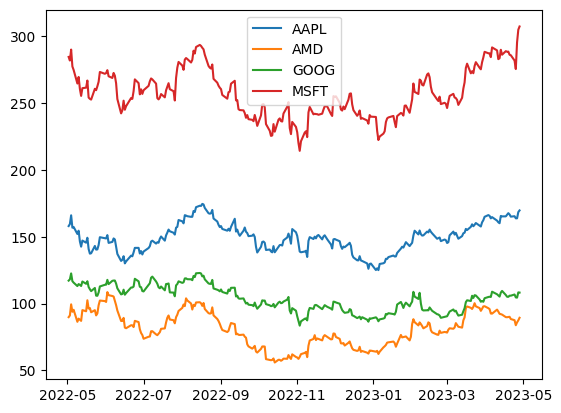

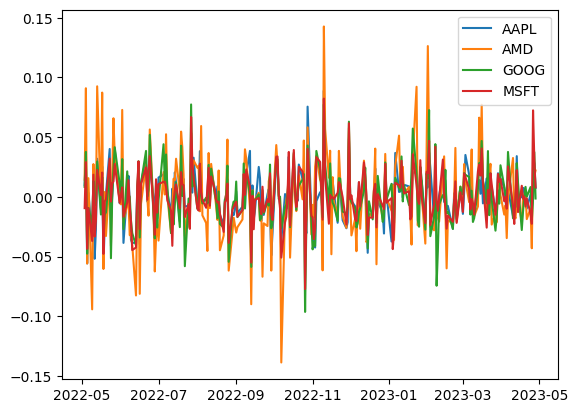

Text(0.5, 1.0, 'AMD')

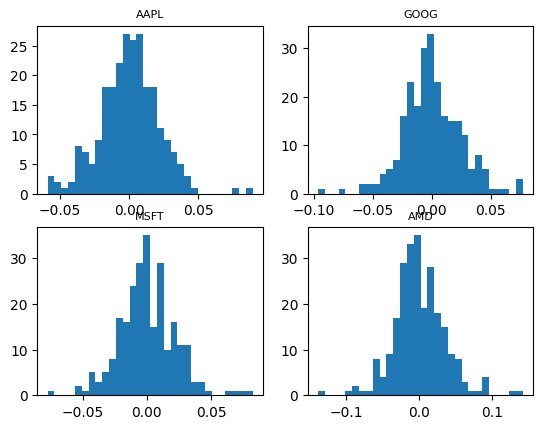

In [32]:
returns, data, mean_returns, cov_matrix = Returns(stocks,end=end,start=start)
plt.plot(data['Close'])
plt.legend(data['Close'].columns)
plt.show()

plt.plot(returns)
plt.legend(returns.columns)
plt.show()
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(returns['AAPL'],bins=30)
axs[0, 0].set_title('AAPL',size=8)
axs[0, 1].hist(returns['GOOG'],bins=30)
axs[0, 1].set_title('GOOG',size=8)
axs[1, 0].hist(returns['MSFT'],bins=30)
axs[1, 0].set_title('MSFT',size=8)
axs[1, 1].hist(returns['AMD'],bins=30)
axs[1, 1].set_title('AMD',size=8)


In [33]:
returns, data, mean_returns, cov_matrix = Returns(stocks,end=end,start=start)
weights = pd.Series(weights,index=mean_returns.index)
portofolio_returns, portofolio_std = Portofolio_Returns(weights, mean_returns, cov_matrix, trading_days)

maximum_sh = Maximum_Sharpe_Ratio(mean_returns, cov_matrix, trading_days)
print("Portofolio with maximum Sharpe ratio: AAPL: {}%, AMD: {}%, GOOG: {}%, MSFT: {}%".
      format(round(maximum_sh['x'][0]*100,1),round(maximum_sh['x'][1]*100,1),round(maximum_sh['x'][2]*100,1),round(maximum_sh['x'][3]*100,1)))
minimum_vr = Minimize_Variance(mean_returns, cov_matrix, trading_days)
print("Portofolio with minimum volatility: AAPL: {}%, AMD: {}%, GOOG: {}%, MSFT: {}%".
      format(round(minimum_vr['x'][0]*100,1),round(minimum_vr['x'][1]*100,1),round(minimum_vr['x'][2]*100,1),round(minimum_vr['x'][3]*100,1)))

[*********************100%%**********************]  4 of 4 completed
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Portofolio with maximum Sharpe ratio: AAPL: 41.4%, AMD: 0.1%, GOOG: 0.0%, MSFT: 58.5%
Portofolio with minimum volatility: AAPL: 52.6%, AMD: 0.0%, GOOG: 7.1%, MSFT: 40.3%


In [34]:
max_shr_returns, max_shr_std = Portofolio_Returns(maximum_sh['x'], mean_returns, cov_matrix, trading_days)
print("Returns percentage of the portofolio with the maximum Sharpe ratio: {}%".format(round(max_shr_returns*100,2)))
print("Standard deviation of the portofolio with the maximum Sharpe ratio: {}%".format(round( max_shr_std*100,2)))
min_var_returns, min_var_std = Portofolio_Returns(minimum_vr['x'], mean_returns, cov_matrix, trading_days)
print("Returns percentage of the portofolio with minimum violatility: {}%".format(round(min_var_returns*100,2)))
print("Standard deviation of the portofolio with minimum violatility: {}%".format(round(min_var_std*100,2)))

Returns percentage of the portofolio with the maximum Sharpe ratio: 13.39%
Standard deviation of the portofolio with the maximum Sharpe ratio: 32.34%
Returns percentage of the portofolio with minimum violatility: 12.31%
Standard deviation of the portofolio with minimum violatility: 32.25%


In [35]:
efficient_opt = Efficient_Opt(mean_returns, cov_matrix, trading_days, returnTarget=0.1)
print("Portofolio with return target=10%: AAPL: {}%, AMD: {}%, GOOG: {}%, MSFT: {}%".
      format(round(efficient_opt['x'][0]*100,1),round(efficient_opt['x'][1]*100,1),round(efficient_opt['x'][2]*100,1),round(efficient_opt['x'][3]*100,1)))

Portofolio with return target=10%: AAPL: 55.0%, AMD: 0.0%, GOOG: 2.7%, MSFT: 42.3%


In [36]:
eff_returns, eff_std = Portofolio_Returns(efficient_opt['x'], mean_returns, cov_matrix, trading_days)
print("Returns percentage of the portofolio with return target=10%: {}%".format(round(eff_returns*100,2)))
print("Standard deviation of the portofolio with return target=10%: {}%".format(round(eff_std*100,2)))

Returns percentage of the portofolio with return target=10%: 12.91%
Standard deviation of the portofolio with return target=10%: 32.22%


In [37]:
np.random.seed(78)
tries = 100000
results_weights, results_returns, results_std = [], [], []
minimum_variance = {'variance':1,'returns':0,'weights':[]}
for i in range(tries):
     
    weights = np.random.rand(len(stocks))
    weights/=np.sum(weights)
    results_weights.append(weights)
    returns, std = Portofolio_Returns(weights, mean_returns, cov_matrix, trading_days)
    results_returns.append(returns)
    results_std.append(std)
    if std<minimum_variance['variance']:
        minimum_variance['variance'], minimum_variance['returns'], minimum_variance['weights'] = std, returns , weights
    if std==minimum_variance['variance'] and returns>minimum_variance['returns']:
        minimum_variance['variance'], minimum_variance['returns'], minimum_variance['weights'] = std, returns , weights

In [38]:
print("Portofolio with minimum volatility using a simulation: AAPL: {}%, AMD: {}%, GOOG: {}%, MSFT: {}%".
      format(round(minimum_variance['weights'][0]*100,1),round(minimum_variance['weights'][1]*100,1),
             round(minimum_variance['weights'][2]*100,1),round(minimum_variance['weights'][3]*100,1)))
print("Returns percentage of the portofolio with minimum volatility using a simulation: {}%".format(round(minimum_variance['returns']*100,2)))
print("Standard deviation of the portofolio with minimum volatility using a simulation: {}%".format(round(minimum_variance['variance']*100,2)))

Portofolio with minimum volatility using a simulation: AAPL: 56.3%, AMD: 0.1%, GOOG: 0.7%, MSFT: 42.8%
Returns percentage of the portofolio with minimum volatility using a simulation: 13.19%
Standard deviation of the portofolio with minimum volatility using a simulation: 32.23%


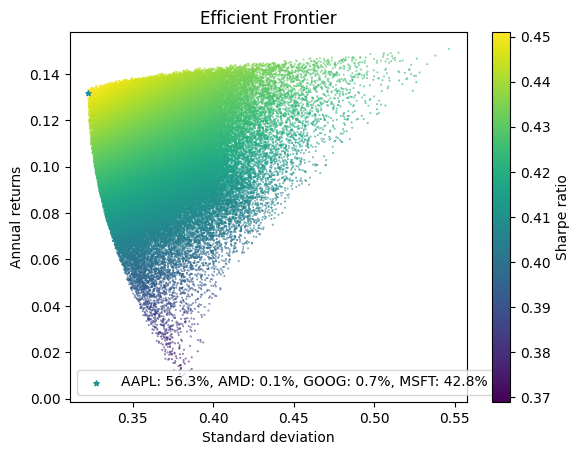

In [39]:
plt.scatter(results_std,results_returns,c=np.array(results_returns)/np.array(results_std),s=0.1
            ,vmin=min(np.array(results_returns)/np.array(results_std)), vmax=max(np.array(results_returns)/np.array(results_std)))
plt.scatter(minimum_variance['variance'],minimum_variance['returns'],c=np.round(minimum_variance['returns']/minimum_variance['variance'],2),
            s=15,marker='*',label='AAPL: {}%, AMD: {}%, GOOG: {}%, MSFT: {}%'.format(np.round(minimum_variance['weights'][0]*100,1),
         np.round(minimum_variance['weights'][1]*100,1),np.round(minimum_variance['weights'][2]*100,1),np.round(minimum_variance['weights'][3]*100,1)
            ))
plt.xlabel('Standard deviation')
plt.ylabel('Annual returns')
plt.colorbar(label='Sharpe ratio')
plt.title('Efficient Frontier')
plt.legend()
plt.show()

In [40]:
def Historical_VAR(returns,conf_inter=5):
    if isinstance(returns,pd.Series): return np.percentile(returns,conf_inter)
    elif isinstance(returns,pd.DataFrame): return returns.aggregate(Historical_VAR,conf_inter=conf_inter)
    else: raise TypeError("Wrong type of data. Supported types are pandas.Series and pandas.DataFrame")
        
def Historical_CVAR(returns,conf_inter=5):
    if isinstance(returns,pd.Series): 
        belowVAR = returns[returns<=Historical_VAR(returns,conf_inter=conf_inter)]
        return belowVAR.mean()
    elif isinstance(returns,pd.DataFrame): return returns.aggregate(Historical_CVAR,conf_inter=conf_inter)
    else: raise TypeError("Wrong type of data. Supported types are pandas.Series and pandas.DataFrame")
        
def Parametric_VAR(portofolio_returns,portofolio_std, distribution='normal', conf_inter =5, dof=6):
    if distribution=='normal':
        var = norm.ppf(1-conf_inter/100)*portofolio_std-portofolio_returns
    elif distribution=='t':
        var = np.sqrt((dof-2)/dof) * t.ppf(1-conf_inter/100, dof) * portofolio_std - portofolio_returns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return var
        
def Parametric_CVAR(portofolio_returns,portofolio_std, distribution='normal', conf_inter =5, dof=6):
    if distribution=='normal':
        cvar = (conf_inter/100)**(-1)*norm.pdf(norm.ppf(conf_inter/100))*portofolio_std-portofolio_returns
    elif distribution=='t':
        x = t.ppf(conf_inter/100, dof)
        cvar = -(conf_inter/100)**(-1) * (1-dof)**(-1) * (dof-2+x**2) * t.pdf(x, dof) * portofolio_std - portofolio_returns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return cvar

In [41]:
returns, data, mean_returns, cov_matrix = Returns(stocks,end=end,start=start)
weights = np.array([np.round(minimum_variance['weights'][0],1), np.round(minimum_variance['weights'][1],1),
                   np.round(minimum_variance['weights'][2],1),np.round(minimum_variance['weights'][3],1)])
weights = pd.Series(weights,index=mean_returns.index) 
returns = returns.dropna()
returns['portofolio_return'] = returns.dot(weights)
returns.head()

[*********************100%%**********************]  4 of 4 completed


Ticker          AAPL       AMD      GOOG      MSFT  portofolio_return
Date                                                                 
2022-05-03  0.009623  0.014359  0.008301 -0.009456           0.001991
2022-05-04  0.041008  0.090969  0.037632  0.029101           0.036245
2022-05-05 -0.055716 -0.055824 -0.047550 -0.043555          -0.050852
2022-05-06  0.003253  0.015660 -0.009306 -0.009447          -0.001827
2022-05-09 -0.033189 -0.094189 -0.022272 -0.036945          -0.034692

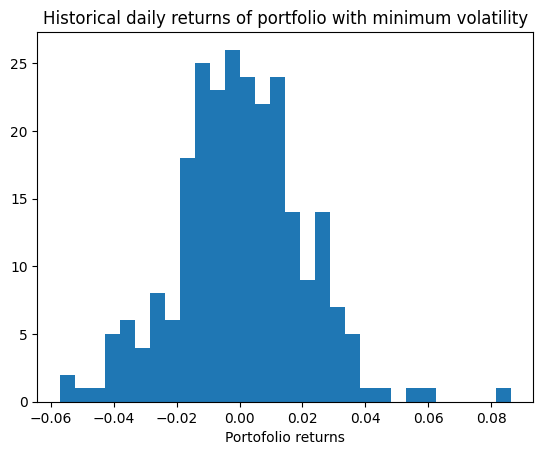

In [42]:
plt.hist(returns['portofolio_return'],bins=30)
plt.xlabel('Portofolio returns')
plt.title('Historical daily returns of portfolio with minimum volatility')
plt.show()

In [43]:
historical_var_95 = -Historical_VAR(returns['portofolio_return'],conf_inter=5)*np.sqrt(trading_days)
historical_cvar_95 = -Historical_CVAR(returns['portofolio_return'],conf_inter=5)*np.sqrt(trading_days)
portofolio_returns, portofolio_std = Portofolio_Returns(weights, mean_returns, cov_matrix, trading_days)

InitialInvestment = 10000
print('Expected Portfolio Return:      ', round(InitialInvestment*portofolio_returns,2))
print('Value at Risk 95th CI    :      ', round(InitialInvestment*historical_var_95,2))
print('Conditional VaR 95th CI  :      ', round(InitialInvestment*historical_cvar_95,2))

Expected Portfolio Return:       1326.0
Value at Risk 95th CI    :       5574.13
Conditional VaR 95th CI  :       6817.17


In [44]:
portofolio_returns, portofolio_std = Portofolio_Returns(weights, mean_returns, cov_matrix, trading_days)

norm_var_95 = Parametric_VAR(portofolio_returns, portofolio_std,conf_inter=5)
norm_cvar_95 = Parametric_CVAR(portofolio_returns, portofolio_std,conf_inter=5)

t_var_95 = Parametric_VAR(portofolio_returns, portofolio_std,distribution='t',conf_inter=5)
t_cvar_95 = Parametric_CVAR(portofolio_returns, portofolio_std,distribution='t',conf_inter=5)

print('Normal Value at Risk 95th CI    :      ', round(InitialInvestment*norm_var_95,2))
print('Normal Conditional VaR 95th CI  :      ', round(InitialInvestment*norm_cvar_95,2))

print('t Value at Risk 95th CI    :      ', round(InitialInvestment*t_var_95,2))
print('t Conditional VaR 95th CI  :      ', round(InitialInvestment*t_cvar_95,2))

Normal Value at Risk 95th CI    :       3978.65
Normal Conditional VaR 95th CI  :       5326.25
t Value at Risk 95th CI    :       3790.79
t Conditional VaR 95th CI  :       5627.63


**MC SIMULATION OF THE PORTFOLIO**

In [45]:
def MC_VAR(returns,conf_inter=5):
    if isinstance(returns,pd.Series):
        return np.percentile(returns,conf_inter)
    else: raise TypeError("Expected pandas.Series object.")
        
def MC_CVAR(returns,conf_inter=5):
    if isinstance(returns,pd.Series):
        belowVAR = returns[returns<=MC_VAR(returns,conf_inter=conf_inter)]
        return belowVAR.mean()
    else: raise TypeError("Expected pandas.Series object.")

[*********************100%%**********************]  4 of 4 completed


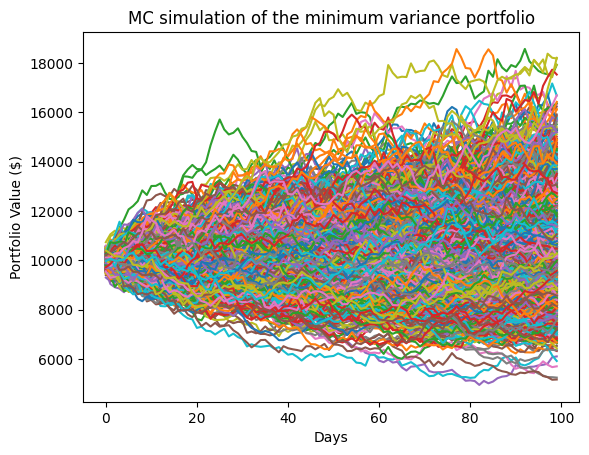

In [46]:
returns, data, mean_returns, cov_matrix = Returns(stocks,end=end,start=start)
weights = np.array([np.round(minimum_variance['weights'][0],1), np.round(minimum_variance['weights'][1],1),
                   np.round(minimum_variance['weights'][2],1),np.round(minimum_variance['weights'][3],1)])
weights = pd.Series(weights,index=mean_returns.index) 
iterations = 1000
days_of_simulation = 100
InitialInvestment = 10000

meanreturns = np.full(shape=(days_of_simulation, len(weights)),fill_value=mean_returns).T
portfolio_sims = np.full(shape=(days_of_simulation, iterations), fill_value=0.0)
for i in range(iterations):
    Z = np.random.normal(size=(days_of_simulation, len(weights)))#uncorrelated RV's
    L = np.linalg.cholesky(cov_matrix) #Cholesky decomposition to Lower Triangular Matrix
    daily_returns = meanreturns + np.inner(L, Z) #Correlated daily returns for individual stocks
    portfolio_sims[:,i] = np.cumprod(np.inner(weights, daily_returns.T)+1)*InitialInvestment
    
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of the minimum variance portfolio')
plt.show()

In [51]:
returns_of_simulation = pd.Series(portfolio_sims[-1,:])
print('MC VaR 95th CI : {}'.format(round(InitialInvestment-MC_VAR(returns_of_simulation,conf_inter=5)),2))
print('MC CVaR 95th CI: {}'.format(round(InitialInvestment-MC_CVAR(returns_of_simulation,conf_inter=5)),2))

MC VaR 95th CI : 2680
MC CVaR 95th CI: 3202
